**Name: SOUHARDO RAHMAN**<br>

**ID: 22-49068-3**

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

In [72]:
DATASET_PATH = "/content/drive/MyDrive/CVPR/animal_dataset"
IMG_SIZE = (32, 32)
K_VALUES = range(1, 21)
FOLDS = 5

# Manhattan Distance calculation
def l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2), axis=1)

# Euclidian Distance calculation
def l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2, axis=1))

# KNN (L1 + L2)
def predict_knn(X_train, y_train, X_test, k, metric='l2'):
    predictions = []

    for test_point in X_test:
        if metric == 'l1':
            distances = l1_distance(X_train, test_point)
        else:
            distances = l2_distance(X_train, test_point)

        k_indices = np.argsort(distances)[:k]

        k_nearest_labels = [y_train[i] for i in k_indices]

        most_common = Counter(k_nearest_labels).most_common(1)
        predictions.append(most_common[0][0])

    return np.array(predictions)

# Accuracy Formula (TP+FP)/(P+N)
def get_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

Found classes: ['cat', 'dog', 'panda']


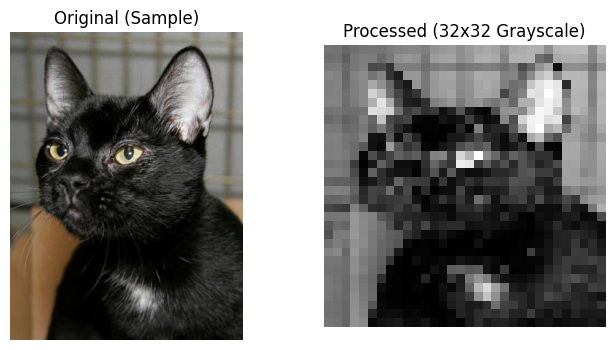

Total images loaded: 300
Feature vector shape: (300, 1024)


In [73]:
def load_and_preprocess_data(path):
    data = []
    labels = []
    label_map = {}

    if not os.path.exists(path):
        print(f"Error: Path {path} not found.")
        return None, None, None

    classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    print(f"Found classes: {classes}")

    # Store a sample for visualization
    sample_original = None
    sample_processed = None

    for idx, label_name in enumerate(classes):
        label_map[idx] = label_name
        class_path = os.path.join(path, label_name)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)
            if img is None: continue

            if sample_original is None:
                sample_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Preprocessing
            img_resized = cv2.resize(img, IMG_SIZE)
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            img_flat = img_gray.flatten()

            if sample_processed is None:
                sample_processed = img_gray

            data.append(img_flat)
            labels.append(idx)

    return np.array(data), np.array(labels), label_map, sample_original, sample_processed

# Execution
X, y, label_map, sample_orig, sample_proc = load_and_preprocess_data(DATASET_PATH)

# Shuffle data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Visualize Pre vs Post processing
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original (Sample)")
plt.imshow(sample_orig)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Processed (32x32 Grayscale)")
plt.imshow(sample_proc, cmap='gray')
plt.axis('off')
plt.show()

print(f"Total images loaded: {len(X)}")
print(f"Feature vector shape: {X.shape}")

In [74]:
# Storage for results
# Structure: {'l1': {k: [acc_fold1, acc_fold2...]}, 'l2': ...}
results = {
    'l1': {k: [] for k in K_VALUES},
    'l2': {k: [] for k in K_VALUES}
}

fold_size = len(X) // FOLDS

print("Starting 5-Fold Cross-Validation...")

# Iterate through each fold
for i in range(FOLDS):
    # Split Train/Val
    start = i * fold_size
    end = (i + 1) * fold_size

    X_val = X[start:end]
    y_val = y[start:end]

    # Train skipping the test set
    X_train = np.concatenate((X[:start], X[end:]), axis=0)
    y_train = np.concatenate((y[:start], y[end:]), axis=0)

    print(f"Processing Fold {i+1}/{FOLDS}...")

    # Calculate distance matrix ONCE per fold for test set
    for k in tqdm(K_VALUES, desc=f"Fold {i+1} L1 & L2", leave=False):
        # Predict L1
        pred_l1 = predict_knn(X_train, y_train, X_val, k, metric='l1')
        acc_l1 = get_accuracy(y_val, pred_l1)
        results['l1'][k].append(acc_l1)

        # Predict L2
        pred_l2 = predict_knn(X_train, y_train, X_val, k, metric='l2')
        acc_l2 = get_accuracy(y_val, pred_l2)
        results['l2'][k].append(acc_l2)

print("\nCross-Validation Complete.")

Starting 5-Fold Cross-Validation...
Processing Fold 1/5...


Processing Fold 2/5...


Processing Fold 3/5...


Processing Fold 4/5...


Processing Fold 5/5...



Cross-Validation Complete.


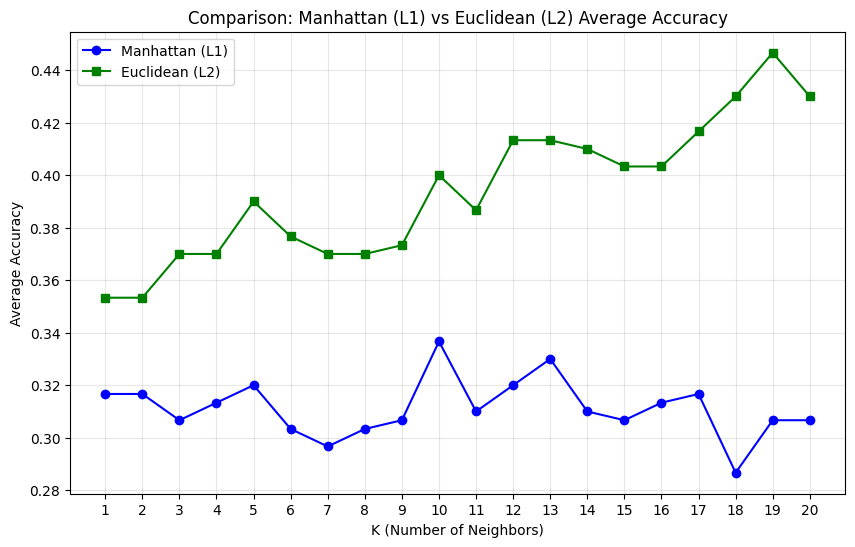

Best K for L1: 10 with accuracy 0.3367
Best K for L2: 19 with accuracy 0.4467


In [75]:
# Calculate Averages
l1_avgs = [np.mean(results['l1'][k]) for k in K_VALUES]
l2_avgs = [np.mean(results['l2'][k]) for k in K_VALUES]

# Plot Comparison (L1 vs L2)
plt.figure(figsize=(10, 6))
plt.title("Comparison: Manhattan (L1) vs Euclidean (L2) Average Accuracy")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.xticks(K_VALUES)

plt.plot(K_VALUES, l1_avgs, label='Manhattan (L1)', color='blue', marker='o')
plt.plot(K_VALUES, l2_avgs, label='Euclidean (L2)', color='green', marker='s')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print best K for each
best_k_l1 = K_VALUES[np.argmax(l1_avgs)]
best_k_l2 = K_VALUES[np.argmax(l2_avgs)]
print(f"Best K for L1: {best_k_l1} with accuracy {max(l1_avgs):.4f}")
print(f"Best K for L2: {best_k_l2} with accuracy {max(l2_avgs):.4f}")

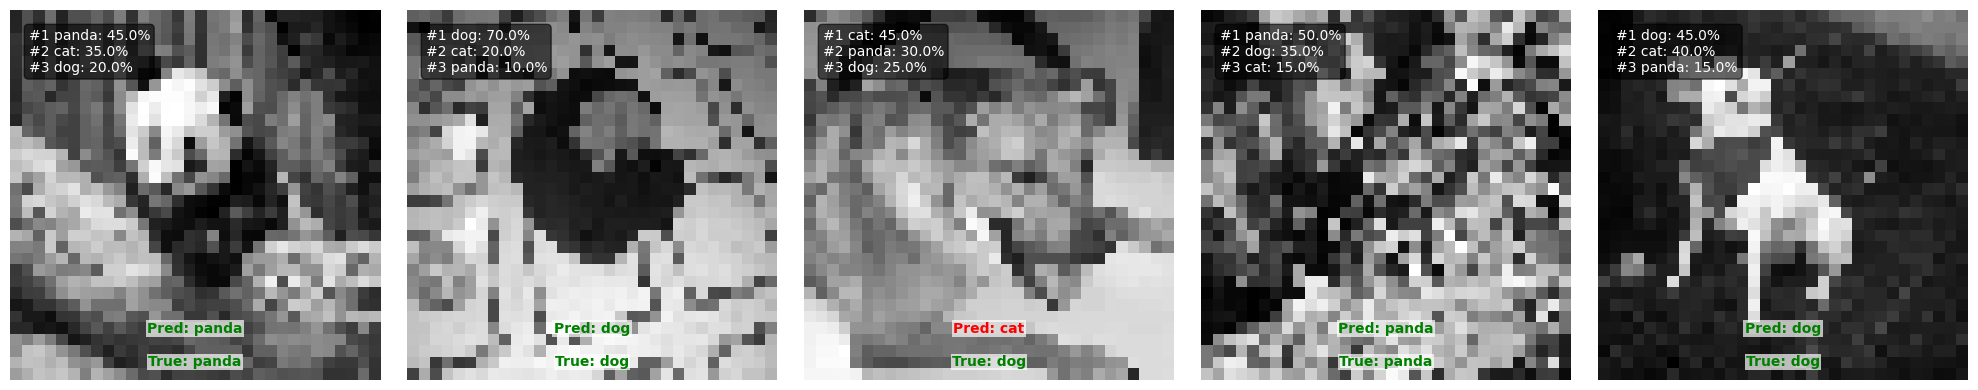

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def TopK(X_train, y_train, X_test_samples, y_test_labels, label_map, k_neighbors=10, n_top=5):
    n_samples = len(X_test_samples)
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(4 * n_samples, 4))

    # Handle single image case
    if n_samples == 1:
        axes = [axes]

    for i, (test_point, true_label_idx) in enumerate(zip(X_test_samples, y_test_labels)):
        ax = axes[i]

        # Calculate Distances
        distances = np.sqrt(np.sum((X_train - test_point)**2, axis=1))

        # Find Neighbors
        k_indices = np.argsort(distances)[:k_neighbors]
        k_nearest_labels = [y_train[j] for j in k_indices]

        # Probabilities
        vote_counts = Counter(k_nearest_labels)
        total_votes = k_neighbors

        probs = []
        unique_classes = np.unique(y_train)
        for class_idx in unique_classes:
            count = vote_counts.get(class_idx, 0)
            probability = (count / total_votes) * 100
            probs.append((class_idx, probability))

        # Sort
        probs.sort(key=lambda x: x[1], reverse=True)
        top_n_preds = probs[:n_top]

        # Best Prediction
        pred_label_idx = top_n_preds[0][0]



        # Display Image
        img_reshaped = test_point.reshape(32, 32)
        ax.imshow(img_reshaped, cmap='gray')

        # Overlay Top-N Text
        text_lines = []
        for rank, (cls_idx, score) in enumerate(top_n_preds):
            name = label_map.get(cls_idx, f"Class {cls_idx}")
            text_lines.append(f"#{rank+1} {name}: {score:.1f}%")

        overlay_text = "\n".join(text_lines)
        ax.text(0.05, 0.95, overlay_text,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                color='white',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.6))

        # Labels at Bottom
        pred_name = label_map.get(pred_label_idx, f"Class {pred_label_idx}")
        true_name = label_map.get(true_label_idx, f"Class {true_label_idx}")

        # Determine Color for Prediction
        is_correct = (pred_label_idx == true_label_idx)
        pred_color = 'green' if is_correct else 'red'

        # Prediction Label
        ax.text(0.5, 0.12, f"Pred: {pred_name}",
                transform=ax.transAxes,
                ha='center', va='bottom',
                color=pred_color, weight='bold',
                bbox=dict(boxstyle='square,pad=0.1', facecolor='white', alpha=0.7, edgecolor='none'))

        # True Label
        ax.text(0.5, 0.03, f"True: {true_name}",
                transform=ax.transAxes,
                ha='center', va='bottom',
                color='green', weight='bold',
                bbox=dict(boxstyle='square,pad=0.1', facecolor='white', alpha=0.7, edgecolor='none'))

        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Select 5 random samples
indices = np.random.choice(len(X), 5, replace=False)
test_X = X[indices]
test_y = y[indices]

# Run Visualization
TopK(X, y, test_X, test_y, label_map, k_neighbors=20, n_top=5)

**Discussion**

1.   Using 5-fold cross-validation, Euclidean (L2) distance performed better than Manhattan (L1) for this dataset, achieving the highest accuracy of 44.67% with K = 19.

2.   The dataset consists of 3 classes (cat, dog, panda) preprocessed into 32×32 grayscale images. While converting to grayscale reduces computational complexity, it discards color information that is often discriminative for these animals, leading to significant feature overlap.

3. Euclidean (L2) distance appeared better suited for this specific feature space compared to Manhattan (L1), likely because the squared differences in L2 provide a stronger signal for separating the pixel intensity vectors of these classes.

**LIMITATION:** The overall accuracy is relatively low (<50%), highlighting that raw pixel intensity is a poor feature for classification. The model is also constrained by the low image resolution


**POTENTIAL IMPROVEMENTS:** Retaining RGB color channels, increasing image resolution, applying data augmentation, or employing deep learning models like CNNs would likely yield significant performance gains.


